In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2 as cv
import math

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

In [2]:
df_train = pd.read_csv('train.csv')
df_val = pd.read_csv('val.csv')
df_test = pd.read_csv('test.csv')
df_test.head()

,ID,Epidural,Intraparenchymal,Intraventricular,Subarachnoid,Subdural
0,ID_d2a94c3b7.png,0,0,0,0,1
1,ID_d2a98c0f1.png,0,0,1,1,0
2,ID_d2a9d6921.png,0,1,0,1,0
3,ID_d2a9f7ff7.png,0,0,0,0,1
4,ID_d2aa11e41.png,0,0,0,1,1


In [3]:
labels = ['Epidural','Intraparenchymal','Intraventricular','Subarachnoid','Subdural']

In [4]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=16, seed=1):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """        
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        rotation_range = 90,
                                        shear_range=0.2,
                                        zoom_range=0.1,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        fill_mode='nearest', cval=0.0)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed)
    
    return generator

def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, 
                                 sample_size=500, batch_size=16, seed=1):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="ID", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True)
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed)

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed)
    
    return valid_generator, test_generator

IMAGE_DIR = "C:/Users/asarkar.NATICK-NT/ICH_dataset/ICH_png"
train_generator = get_train_generator(df_train, IMAGE_DIR, "ID", labels)
valid_generator, test_generator= get_test_and_valid_generator(df_val, df_test, df_train, IMAGE_DIR, "ID", labels)

getting train generator...
Found 74790 validated image filenames.
getting train and valid generators...
Found 74790 validated image filenames.
Found 10000 validated image filenames.
Found 17101 validated image filenames.


In [5]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    
    # total number of patients (rows)
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels==True,axis=0)/N
    negative_frequencies = np.sum(labels==False, axis=0)/N

    return positive_frequencies, negative_frequencies

freq_pos, freq_neg = compute_class_freqs(train_generator.labels)

pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0

        for i in range(len(pos_weights)):
            
            y_true = tf.cast(y_true, tf.float32)
            y_pred = tf.cast(y_pred, tf.float32)
            

            # for each class, add average weighted loss for that class 
            loss += K.mean(-(pos_weights[i] *y_true[:,i] * K.log(y_pred[:,i] + epsilon) 
                     + neg_weights[i]* (1 - y_true[:,i]) * K.log( 1 - y_pred[:,i] + epsilon)))   
            
        return loss
    
    return weighted_loss

In [6]:
model_1 = tf.keras.models.load_model('EfficientNetB4_imagenet_sgd.h5', compile = False)
model_1.compile(optimizer='sgd', loss=get_weighted_loss(pos_weights, neg_weights), metrics = ['accuracy'])

model_2 = tf.keras.models.load_model('EfficientNetB4_noisy_sgd.h5', compile = False)
model_2.compile(optimizer='sgd', loss=get_weighted_loss(pos_weights, neg_weights), metrics = ['accuracy'])

model_3 = tf.keras.models.load_model('EfficientNetB4_imagenet_adam.h5', compile = False)
model_3.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights), metrics = ['accuracy'])

model_4= tf.keras.models.load_model('EfficientNetB4_noisy_adam.h5', compile = False)
model_4.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights), metrics = ['accuracy'])

In [7]:
P1 = model_1.predict(test_generator, steps = len(test_generator))
P2 = model_2.predict(test_generator, steps = len(test_generator))
P3 = model_3.predict(test_generator, steps = len(test_generator))
P4 = model_4.predict(test_generator, steps = len(test_generator))

In [8]:
weighted_pred = (0.45*P1+0.45*P2+0.05*P3+0.05*P4)
weighted_pred

array([[5.0843502e-03, 9.3965260e-05, 4.5387380e-05, 1.1160626e-03,
        9.9992269e-01],
       [7.3475237e-03, 3.9971910e-02, 9.7079098e-01, 8.5149831e-01,
        1.9753067e-01],
       [7.6330379e-02, 9.9500066e-01, 2.5628679e-02, 1.8933630e-01,
        9.4683945e-01],
       ...,
       [1.1286439e-03, 8.5642052e-01, 9.9301499e-01, 7.7719921e-03,
        8.4860873e-04],
       [1.0945840e-02, 5.1649651e-03, 2.5616568e-03, 9.9810302e-01,
        3.6492315e-01],
       [1.1346705e-03, 3.3737391e-02, 9.9594319e-01, 1.0192080e-01,
        3.7487857e-03]], dtype=float32)

In [9]:
weighted_pred = np.around(weighted_pred)
final_pred = weighted_pred.astype(int)
final_pred

array([[0, 0, 0, 0, 1],
       [0, 0, 1, 1, 0],
       [0, 1, 0, 0, 1],
       ...,
       [0, 1, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0]])

Confusion matrix for label Epidural:


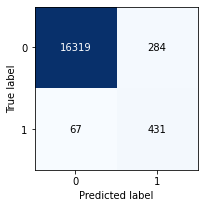

Metrics for label : Epidural

Sensitivity-Recall : 0.8654618473895582
Precision - PPV : 0.6027972027972028
Accuracy : 0.9794748845096778
F-score : 0.7106347897774113

Confusion matrix for label Intraparenchymal:


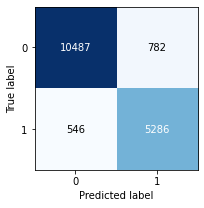

Metrics for label : Intraparenchymal

Sensitivity-Recall : 0.9063786008230452
Precision - PPV : 0.8711272247857613
Accuracy : 0.9223437225893223
F-score : 0.8884033613445378

Confusion matrix for label Intraventricular:


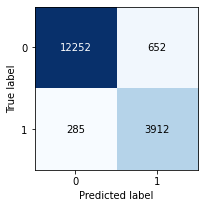

Metrics for label : Intraventricular

Sensitivity-Recall : 0.9320943531093638
Precision - PPV : 0.8571428571428571
Accuracy : 0.9452078825799661
F-score : 0.8930487387284557

Confusion matrix for label Subarachnoid:


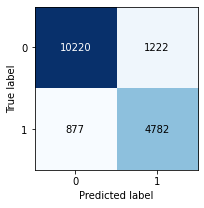

Metrics for label : Subarachnoid

Sensitivity-Recall : 0.8450256229015727
Precision - PPV : 0.796469020652898
Accuracy : 0.877258639845623
F-score : 0.8200291520192059

Confusion matrix for label Subdural:


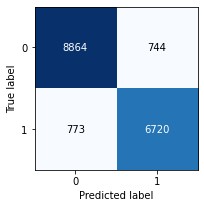

Metrics for label : Subdural

Sensitivity-Recall : 0.896837047911384
Precision - PPV : 0.9003215434083601
Accuracy : 0.9112917373253027
F-score : 0.8985759176305409

Metrics for Model

Sensitivity-Recall : 0.8923941044807635
Precision - PPV : 0.8515414064074148
Accuracy : 0.9271153733699784
F-score : 0.8714892564028539


In [12]:
predicted_vals = final_pred

from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

TP_all =0
TN_all =0
FP_all =0
FN_all =0

conf_mat_dict={}

for i in range(len(labels)):
    gt = test_generator.labels[:, i]
    pred = predicted_vals[:, i]
    pred = np.rint(pred)
    conf_mat_dict[labels[i]] = confusion_matrix(y_pred=pred, y_true=gt)
    
for label, matrix in conf_mat_dict.items():
    print("Confusion matrix for label {}:".format(label))
    plot_confusion_matrix(matrix,figsize=(3,3))
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()
    
    TN = matrix[0][0]
    FN = matrix[1][0]
    TP = matrix[1][1]
    FP = matrix[0][1]
    
    print("Metrics for label : {}".format(label))
    print("")
    
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    print("Sensitivity-Recall : {}".format(TPR))
    
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    print("Precision - PPV : {}".format(PPV))
    
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    print("Accuracy : {}".format(ACC))
    
    #F-score
    F_score = (2*PPV*TPR)/(PPV+TPR)
    print("F-score : {}".format(F_score))
    print("")
    
    TP_all = TP_all + TP
    TN_all = TN_all + TN
    FP_all = FP_all + FP
    FN_all = FN_all + FN
    
print("Metrics for Model")
print("")
    
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP_all/(TP_all+FN_all)
print("Sensitivity-Recall : {}".format(TPR))
    
# Precision or positive predictive value
PPV = TP_all/(TP_all+FP_all)
print("Precision - PPV : {}".format(PPV))
    
# Overall accuracy
ACC = (TP_all+TN_all)/(TP_all+FP_all+FN_all+TN_all)
print("Accuracy : {}".format(ACC))
    
#F-score
F_score = (2*PPV*TPR)/(PPV+TPR)
print("F-score : {}".format(F_score))